<a href="https://colab.research.google.com/github/dainfinity/PyEx2/blob/master/FreeFall/PINN_FreeFall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dainfinity/PyEx2/blob/master/FreeFall/PINN_FreeFall.ipynb)

# 必要なライブラリのインストールと、インポート
(pyDOEは結局使っていない気がする)

In [ ]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=aa321abbc1964451df3d927c6a846f139e0ca1ab598a91fba5b3fb28321aeb98
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from IPython.display import clear_output

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
torch.set_default_tensor_type('torch.cuda.FloatTensor')

cuda


# モデル構築

In [ ]:
class PINNsModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    'activation function'
    self.activation = nn.Tanh()

    'loss function'
    self.loss_function = nn.MSELoss(reduction ='mean')

    'Initialise neural network as a list using nn.Modulelist'  
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
    self.iter = 0

    'Xavier Normal Initialization'
    # std = gain * sqrt(2/(input_dim+output_dim))
    for i in range(len(layers)-1):
        
        # weights from a normal distribution with 
        # Recommended gain value for tanh = 5/3?
        nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
        
        # set biases to zero
        nn.init.zeros_(self.linears[i].bias.data)

  def forward(self,X):
        
    if torch.is_tensor(X) != True:         
        X = torch.from_numpy(X).float().to(device).clone()
                  
    #preprocessing input 
    X_s = (X - lb_tf)/(ub_tf - lb_tf)  #feature scaling
    
    #convert to float
    a = X_s.float()

    for i in range(len(layers)-2):
        
        z = self.linears[i](a)
                    
        a = self.activation(z)
        
    a = self.linears[-1](a)
    
    return a
    
  def loss_z0(self,X0, z0):

    loss_z0 = self.loss_function(self.forward(X0), z0)

    return loss_z0

  def loss_v0_z(self, X0,v0z):

    h = X0.clone()

    h.requires_grad = True

    z0 = self.forward(h)

    z0_t = autograd.grad(z0,h,torch.ones([X0.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

    loss_v0_z = self.loss_function(v0z, z0_t)

    return loss_v0_z
  
  def loss_fz(self,X_to_train_f):

    grav_ac = 9.8 #重力加速度

    g = X_to_train_f.clone()
                        
    g.requires_grad = True
        
    z = self.forward(g)

    z_t = autograd.grad(z,g,torch.ones([X_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

    z_tt = autograd.grad(z_t,g,torch.ones(X_to_train_f.shape).to(device), create_graph=True)[0]

    f = z_tt + grav_ac

    loss_fz = self.loss_function(f,fz0_tf)

    return loss_fz
    

  def loss(self, X0, z0, v0z, X_to_train_f):

    loss_z0 = self.loss_z0(X0, z0)

    loss_v0_z = self.loss_v0_z(X0, v0z)

    loss_fz = self.loss_fz(X_to_train_f)

    loss = loss_z0 + loss_v0_z + loss_fz

    return loss


  def closure(self):
          
    optimizer.zero_grad()
    
    loss = self.loss(X0_tf, z0_tf, v0_z_tf, X_tf)
    
    loss.backward(retain_graph=True)
            
    self.iter += 1
    
    if self.iter % 100 == 0:

        error_vec, _ = PINN.test()
    
        print(loss, error_vec)

    return loss   

  def test(self):
                
        z_pred = self.forward(X_sol)
        
        error_vec = torch.linalg.norm((z_sol-z_pred),2)/torch.linalg.norm(z_sol,2)        # Relative L2 Norm of the error (Vector)
        
        z_pred = z_pred.cpu().detach().numpy()
                
        return error_vec, z_pred

# 入力変数、初期条件、微分方程式lossに必要なデータを作る。

In [ ]:
N = 10000
t_f = [0, 1]
v_z0_f = [0, 5]

# 入出力変数を作成
t0 = np.zeros([N, 1])
t0_tf = torch.from_numpy(t0).clone().float().to(device)
z0 = np.zeros([N, 1])
z0_tf = torch.from_numpy(z0).clone().float().to(device)

t_f_min = t_f[0]
t_f_len = t_f[1] - t_f[0]

t_f = t_f_len * np.random.rand(N, 1) + t_f_min

X = t_f
X0 = t0

lb = X.min()
ub = X.max()

# テンソルに変換
X_tf = torch.from_numpy(X).clone().float().to(device).clone()
X0_tf = torch.from_numpy(X0).clone().float().to(device).clone()

# 微分方程式に関する損失を計算するために必要な0テンソル
fz0_tf = torch.zeros(X_tf.shape[0],1).to(device)
v0_z_tf = torch.zeros(X_tf.shape[0],1).to(device)

lb_tf = lb + torch.zeros(X_tf.shape[0],1).to(device)
ub_tf = ub + torch.zeros(X_tf.shape[0],1).to(device)

In [ ]:
print(X_tf.shape)
print(z0_tf.shape)
print(X0_tf.shape)
print(v0_z_tf.shape)
print(fz0_tf.shape)
print(lb_tf.shape)
print(ub_tf.shape)

torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])
torch.Size([10000, 1])


In [ ]:
# testデータを作成(解析解)
import pandas as pd

n = 10000
gra = 9.8
z0 = 0
v0z_sol = 0
t_sol = np.linspace(0,1,n)
t_sol = t_sol.reshape(n,1)
# testの入力
X_sol = torch.from_numpy(t_sol).clone().float().to(device).clone()
X_sol = X_sol
# testの出力
z_sol = z0 + v0z_sol * X_sol - 1 / 2 * gra * X_sol ** 2

In [ ]:
print(X_sol.shape)
print(z_sol.shape)

torch.Size([10000, 1])
torch.Size([10000, 1])


# 学習、評価

In [ ]:
layers = np.array([1,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = PINNsModel(layers)
       
PINN.to(device)

'Neural Network Summary'
print(PINN)

params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
                              max_iter = 250, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)


'Adam Optimizer'
optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 20000

start_time = time.time()

for i in range(max_iter):

    loss = PINN.loss(X0_tf, z0_tf, v0_z_tf, X_tf)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    
    loss.backward() #backprop

    optimizer.step()
    
    if i % (max_iter/10) == 0:

        error_vec, _ = PINN.test()

        print(loss, error_vec)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

PINNsModel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)
tensor(0.0714, grad_fn=<AddBackward0>) tensor(0.0097, grad_fn=<DivBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>) tensor(8.9702e-05, grad_fn=<DivBackward0>)
tensor(1.9952e-05, grad_fn=<AddBackward0>) tensor(6.5560e-05, grad_fn=<DivBackward0>)
tensor(1.8460e-05, grad_fn=<AddBackward0>) tensor(0.8070, grad_fn=<DivBackward0>)
tensor(2.2451e-05, grad_fn=<AddBackward

In [ ]:
_, z_pred = PINN.test()
print(z_pred)
print(z_pred.shape)

[[ 0.01659024]
 [ 0.01658922]
 [ 0.01659089]
 ...
 [-4.8712373 ]
 [-4.8722143 ]
 [-4.873192  ]]
(10000, 1)


# 解析解との比較


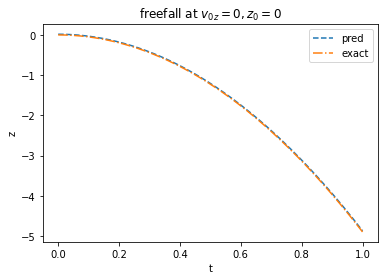

In [ ]:
plt.plot(t_sol, z_pred, label = "pred", linestyle = "dashed")
plt.plot(t_sol, -1/2 * 9.8 * t_sol ** 2, label = "exact", linestyle = "dashdot")
plt.xlabel("t")
plt.ylabel("z")
plt.title("freefall at $v_{0z}=0, z_0=0$")
plt.legend()
plt.savefig("//content//drive//MyDrive//PhyEx2//freeFall_result.png")
plt.show()

# Runge-Kutta法との比較

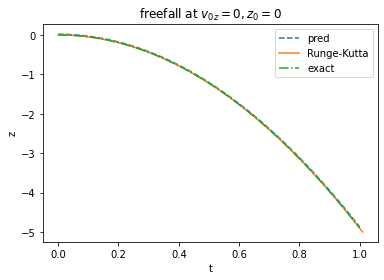

In [ ]:
import numpy as np

g = 9.81 #重力加速度(m/s^2)
k = 0 #空気抵抗なし
m = 10.0 #ボール重さ(kg)

def f(v): #関数の定義
    return (m*g-k*v**2)/m

vtrj = [0.0] #速度のtrajectory配列
xtrj = [0.0] #位置のtrajectory配列
array_t = [0.0] #時間発展配列

v = vtrj[0] #初期速度
x = xtrj[0] #初期位置
t = array_t[0] #初期時間
h = 0.0001 #ルンゲクッタ法の刻み幅

#ルンゲクッタ法のメイン計算
while x >= -5.0 :
    k1 = h*f(v)
    k2 = h*f(v+0.5*k1)
    k3 = h*f(v+0.5*k2)
    k4 = h*f(v+k3)
    v = v + (k1+2*k2+2*k3+k4)/6
    x = x - v*h
    t = t + h
    vtrj = np.append(vtrj,v)
    xtrj = np.append(xtrj,x)
    array_t = np.append(array_t,t)
  
plt.plot(t_sol, z_pred, label = "pred", linestyle = "dashed")
plt.plot(array_t,xtrj, label = "Runge-Kutta")
plt.plot(t_sol, -1/2 * 9.8 * t_sol ** 2, label = "exact", linestyle = "dashdot")
plt.xlabel("t")
plt.ylabel("z")
plt.title("freefall at $v_{0z}=0, z_0=0$")
plt.legend()
plt.show()